<a href="https://colab.research.google.com/github/lgiesen/forest_height/blob/main/notebooks/compare_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# the zipped data is uploaded in the root_path folder
root_path = 'drive/MyDrive/Colab Notebooks/data/'
path_images = f'{root_path}images/'
path_masks = f'{root_path}masks/'
user = "lgiesen"
repo = "forest_height"
color="#01748F"
!git clone https://github.com/{user}/{repo}.git

Cloning into 'forest_height'...
remote: Enumerating objects: 810, done.
remote: Counting objects: 100% (23/23), done.
remote: Compressing objects: 100% (23/23), done.
remote: Total 810 (delta 7), reused 0 (delta 0), pack-reused 787
Receiving objects: 100% (810/810), 114.02 MiB | 10.96 MiB/s, done.
Resolving deltas: 100% (460/460), done.
Updating files: 100% (98/98), done.


In [3]:
import numpy as np
import pandas as pd
import datetime, os, cv2
from matplotlib import pyplot as plt
from matplotlib.ticker import StrMethodFormatter
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error as mse, mean_absolute_error as mae, mean_absolute_percentage_error as mape
from keras.models import Sequential, load_model
from keras.layers import Dense, BatchNormalization, Dropout, InputLayer, Flatten, Conv2D, MaxPool2D, AveragePooling2D
from keras.callbacks import TensorBoard, ModelCheckpoint

In [4]:
%run /content/forest_height/src/load_data.py
%run /content/forest_height/src/evaluate_model.py

Data has been unzipped manually and the filenames have been changed with a prefix to indicate if it belonged to the first or second dataset.

## Load all the images and extract all the labels and the corresponding features

In [20]:
size = 5 #define window size should be odd so that the label is in the middle
shape = (10, size, size) #define shape of features
labels1 = np.ones(1) #array for labels
data1 = np.ones(shape) #array for features
data1 = np.expand_dims(data1, axis=0) #expand dimension to concatenate
for j in range(20): #iterate over images in directory
  if j < 10:
    X = np.load(f'{path_images}1_image_00'+ str(j) + '.npy')
    y = np.load(f'{path_masks}1_mask_00'+ str(j) + '.npy')
    indices = np.argwhere(y > 0) #select all values with label
    indices_2d = indices[:, 1:] #extract indices
    ind_y = np.ones(2).reshape(-1,2) #array to collect indices
    for i in indices_2d: #iterate over indices
      if shape == X[:, i[0] - (size//2):i[0] + (size//2) + 1, i[1] - (size//2):i[1] + (size//2) + 1].shape: #select only features with the same shape because of labels at the image border
        temp = X[:, i[0] - (size//2):i[0] + (size//2) + 1, i[1] - (size//2):i[1] + (size//2) + 1] #save them temporary
        temp2 = np.expand_dims(temp, axis=0) #expand dimension to concatenate
        data1 = np.concatenate((data1, temp2), axis=0) #concatenation

        ind_y = np.concatenate((ind_y, i.reshape(-1,2)), axis=0) #concatenation of index so that they have the same order and length as the features

    ind_y = ind_y[1:] #remove first dummy values
    indices_1 = ind_y[:, 0].astype(int)
    indices_2 = ind_y[:, 1].astype(int)
    data_y = y[0, indices_1, indices_2] #extract labels
    labels1 = np.concatenate((labels1, data_y), axis = 0) #concatenate labels

  if j >= 10:
    X = np.load(f'{path_images}1_image_0'+ str(j) + '.npy')
    y = np.load(f'{path_masks}1_mask_0'+ str(j) + '.npy')
    indices = np.argwhere(y > 0)
    indices_2d = indices[:, 1:]
    ind_y = np.ones(2).reshape(-1,2)
    for i in indices_2d:
      if shape == X[:, i[0] - (size//2):i[0] + (size//2) + 1, i[1] - (size//2):i[1] + (size//2) + 1].shape:
        temp = X[:, i[0] - (size//2):i[0] + (size//2) + 1, i[1] - (size//2):i[1] + (size//2) + 1]
        temp2 = np.expand_dims(temp, axis=0)
        data1 = np.concatenate((data1, temp2), axis=0)

        ind_y = np.concatenate((ind_y, i.reshape(-1,2)), axis=0)

    ind_y = ind_y[1:]
    indices_1 = ind_y[:, 0].astype(int)
    indices_2 = ind_y[:, 1].astype(int)
    data_y = y[0, indices_1, indices_2]
    labels1 = np.concatenate((labels1, data_y), axis = 0)

data1 = data1[1:] #remove first dummy values
labels1 = labels1[1:] #remove first dummy values

In [21]:
shape = (10, size, size)
labels2 = np.ones(1)
data2 = np.ones(shape)
data2 = np.expand_dims(data2, axis=0)
for j in range(20):
  if j < 10:
    X = np.load(f'{path_images}2_image_00'+ str(j) + '.npy')
    y = np.load(f'{path_masks}2_mask_00'+ str(j) + '.npy')
    indices = np.argwhere(y > 0)
    indices_2d = indices[:, 1:]
    ind_y = np.ones(2).reshape(-1,2)
    for i in indices_2d:
      if shape == X[:, i[0] - (size//2):i[0] + (size//2) + 1, i[1] - (size//2):i[1] + (size//2) + 1].shape:
        temp = X[:, i[0] - (size//2):i[0] + (size//2) + 1, i[1] - (size//2):i[1] + (size//2) + 1]
        temp2 = np.expand_dims(temp, axis=0)
        data2 = np.concatenate((data2, temp2), axis=0)

        ind_y = np.concatenate((ind_y, i.reshape(-1,2)), axis=0)

    ind_y = ind_y[1:]
    indices_1 = ind_y[:, 0].astype(int)
    indices_2 = ind_y[:, 1].astype(int)
    data_y = y[0, indices_1, indices_2]
    labels2 = np.concatenate((labels2, data_y), axis = 0)

  if j >= 10:
    X = np.load(f'{path_images}2_image_0'+ str(j) + '.npy')
    y = np.load(f'{path_masks}2_mask_0'+ str(j) + '.npy')
    indices = np.argwhere(y > 0)
    indices_2d = indices[:, 1:]
    ind_y = np.ones(2).reshape(-1,2)
    for i in indices_2d:
      if shape == X[:, i[0] - (size//2):i[0] + (size//2) + 1, i[1] - (size//2):i[1] + (size//2) + 1].shape:
        temp = X[:, i[0] - (size//2):i[0] + (size//2) + 1, i[1] - (size//2):i[1] + (size//2) + 1]
        temp2 = np.expand_dims(temp, axis=0)
        data2 = np.concatenate((data2, temp2), axis=0)

        ind_y = np.concatenate((ind_y, i.reshape(-1,2)), axis=0)

    ind_y = ind_y[1:]
    indices_1 = ind_y[:, 0].astype(int)
    indices_2 = ind_y[:, 1].astype(int)
    data_y = y[0, indices_1, indices_2]
    labels2 = np.concatenate((labels2, data_y), axis = 0)

data2 = data2[1:]
labels2 = labels2[1:]

In [22]:
features = np.concatenate((data1, data2), axis = 0) #concatenate both parts
# ceil values at a reflection value of 2000
features[features > 2000] = 2000
labels = np.concatenate((labels1, labels2), axis = 0)

Neural Network

In [13]:
features_mean = np.mean(features, axis=(2, 3)) # patch mean of size * size features
X_train, X_test, y_train, y_test = train_test_split(features_mean, labels , test_size = 0.3, random_state=3)

In [15]:
nnmodel = load_model('forest_height/models/best_model3.hdf5')
cnnmodel = load_model('forest_height/models/best_modelCnnPred.hdf5')

In [70]:
y_pred_nn = nnmodel.predict(X_test)
mae_nn, mse_nn, rmse_nn, mape_nn = evaluate_model(y_test, y_pred_nnmodel)

362/362 [==============================] - 1s 3ms/step
MAE: 5.270083865915203; MSE: 57.58327028132292; RMSE: 2.295666322860359; MAPE: 0.9070027270806611


Convolutional Neural Network

The CNN takes all 5x5 pixels into consideration seperately and the other models all take the average of the color values as an input.

In [23]:
X_train_cnn, X_test_cnn, y_train_cnn, y_test_cnn = train_test_split(features, labels , test_size = 0.3, random_state=3) #create train, test set

In [69]:
y_pred_cnn = cnnmodel.predict(X_test_cnn)
mae_cnn, mse_cnn, rmse_cnn, mape_cnn = evaluate_model(y_test_cnn, y_pred_cnnmodel)

362/362 [==============================] - 9s 24ms/step
MAE: 4.145201797314169; MSE: 47.60572241204299; RMSE: 2.0359768656136956; MAPE: 0.4730710697381019


Boosted Trees

In [67]:
gbr = GradientBoostingRegressor(n_estimators = 100, max_depth= 1, random_state=1)
gbr.fit(X_train, y_train)
y_pred_gbr = gbr.predict(X_test)
mae_gbr, mse_gbr, rmse_gbr, mape_gbr = evaluate_model(y_test, y_pred_dtr)

MAE: 4.885167658458536; MSE: 51.6374094590859; RMSE: 2.210241538488166; MAPE: 0.7045404257132958


Random Forest

In [43]:
rf = RandomForestRegressor(n_estimators = 400, min_samples_leaf= 0.04, random_state=1)

rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)
mae_rf, mse_rf, rmse_rf, mape_rf = evaluate_model(y_test, y_pred_rf)

MAE: 4.959112148911681; MSE: 53.851151116530026; RMSE: 2.22690640775756; MAPE: 0.7271810385044871


Decision Trees

In [44]:
from sklearn.tree import DecisionTreeRegressor
# initialize model
dt = DecisionTreeRegressor(max_depth=5, min_samples_split=2)
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)
mae_dt, mse_dt, rmse_dt, mape_dt = evaluate_model(y_test, y_pred_dt)

MAE: 4.785731008968664; MSE: 51.74182614709336; RMSE: 2.1876313695338765; MAPE: 0.6726482997397315


In [53]:
save_model(gbr, "boosted_trees_5x5")
save_model(dt, "decision_trees_5x5")
save_model(rf, "random_forest_5x5")

Feature: 0, Score: 0.00298
Feature: 1, Score: 0.76378
Feature: 2, Score: 0.13592
Feature: 3, Score: 0.05024
Feature: 4, Score: 0.00765
Feature: 5, Score: 0.00000
Feature: 6, Score: 0.02296
Feature: 7, Score: 0.00047
Feature: 8, Score: 0.01599
Feature: 9, Score: 0.00000


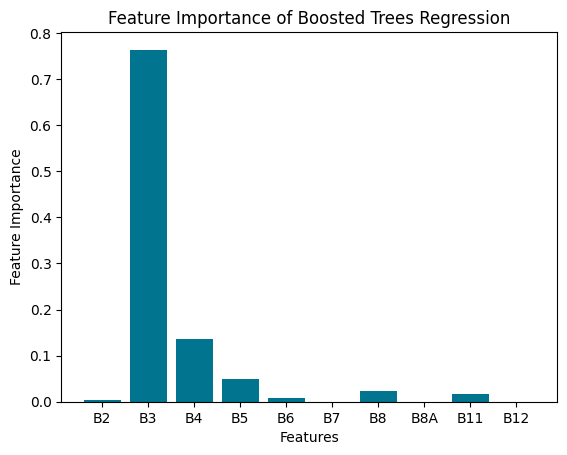

Feature: 0, Score: 0.00000
Feature: 1, Score: 0.94161
Feature: 2, Score: 0.01445
Feature: 3, Score: 0.00142
Feature: 4, Score: 0.00024
Feature: 5, Score: 0.00051
Feature: 6, Score: 0.03554
Feature: 7, Score: 0.00107
Feature: 8, Score: 0.00383
Feature: 9, Score: 0.00134


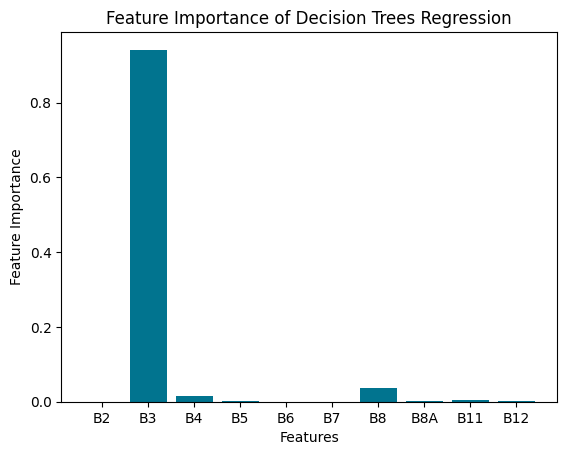

Feature: 0, Score: 0.00385
Feature: 1, Score: 0.96325
Feature: 2, Score: 0.00262
Feature: 3, Score: 0.02246
Feature: 4, Score: 0.00273
Feature: 5, Score: 0.00000
Feature: 6, Score: 0.00355
Feature: 7, Score: 0.00000
Feature: 8, Score: 0.00143
Feature: 9, Score: 0.00010


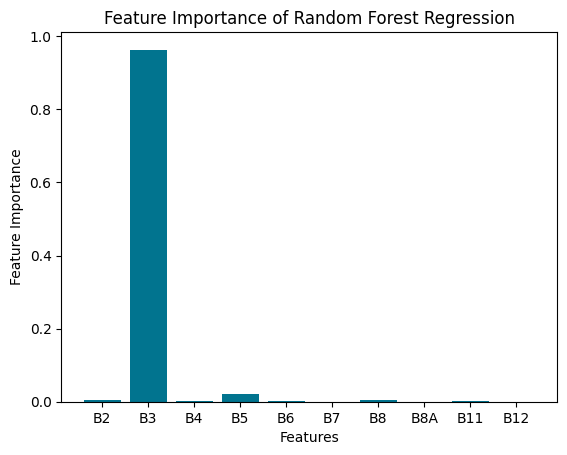

In [52]:
cols = cols=['B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B11', 'B12']
feature_importance(model=gbr, model_name="Boosted Trees", cols=cols)
feature_importance(model=dt, model_name="Decision Trees", cols=cols)
feature_importance(model=rf, model_name="Random Forest", cols=cols)

### Compare Errors

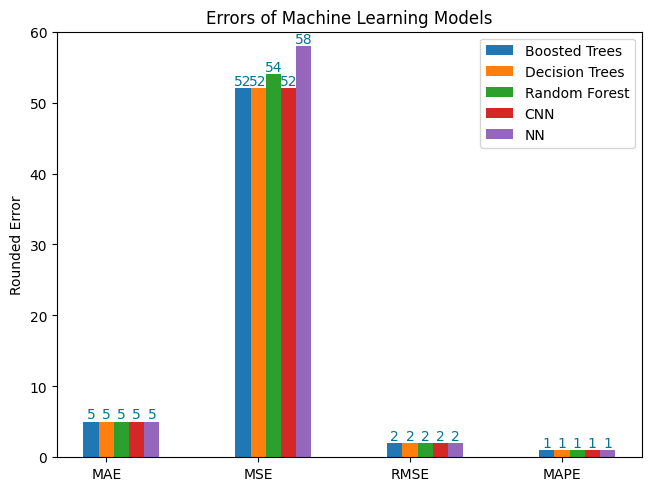

In [59]:
import numpy as np
errors = ("MAE", "MSE", "RMSE", "MAPE")
models = {
    'Boosted Trees': (mae_gbr, mse_gbr, rmse_gbr, mape_gbr),
    'Decision Trees': (mae_dt, mse_dt, rmse_dt, mape_dt),
    'Random Forest': (mae_rf, mse_rf, rmse_rf, mape_rf),
    'CNN': (mae_cnn, mse_cnn, rmse_cnn, mape_cnn),
    'NN': (mae_nn, mse_nn, rmse_nn, mape_nn),
}

x = np.arange(len(errors))  # the label locations
width = 0.1  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for attribute, measurement in models.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, np.round(measurement), width, label=attribute)
    ax.bar_label(rects, padding=0, color=color)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Rounded Error')
ax.set_title('Errors of Machine Learning Models')
ax.set_xticks(x + width, errors)
ax.legend(loc='upper right')
ax.set_ylim(0, 60)

plt.show()

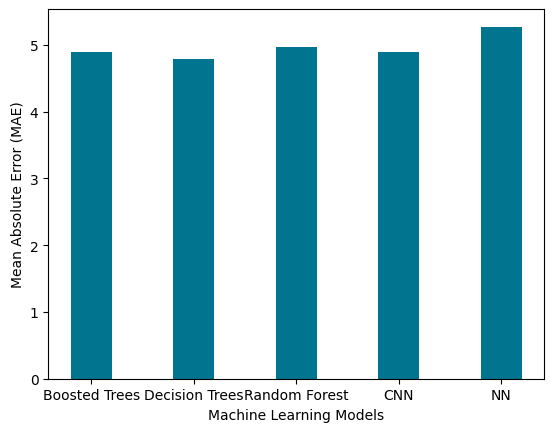

In [65]:
models = ['Boosted Trees', 'Decision Trees', 'Random Forest', 'CNN', 'NN']
errors = [mae_gbr, mae_dt, mae_rf, mae_cnn, mae_nn]
plt.bar(models, errors, color=color, width=.4)
plt.ylabel("Mean Absolute Error (MAE)")
plt.xlabel("Machine Learning Models")
ax.set_title('MAE of Machine Learning Models')
plt.show()

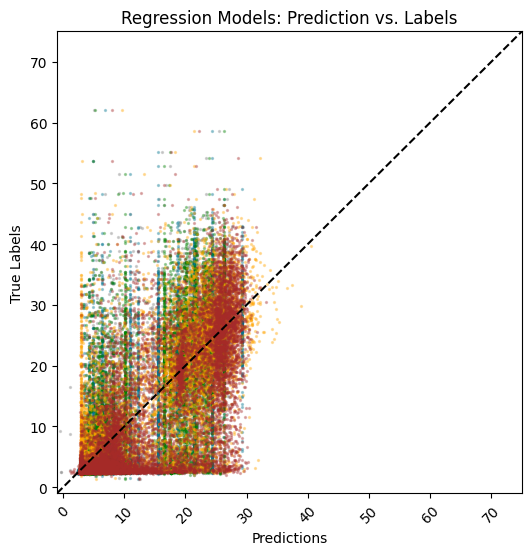

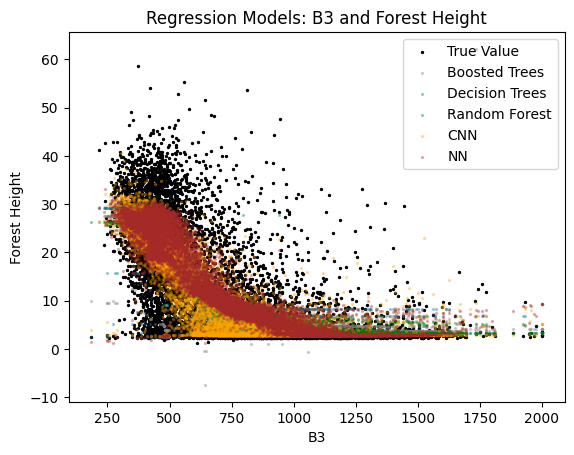

In [74]:
from matplotlib import pyplot as plt
# visualize predictions vs. true labels
fig = plt.figure(figsize=(6,6))
dot_size = 2
alpha = 0.3
plt.scatter(y_pred_gbr, y_test, dot_size, color='gray', alpha=alpha)
plt.scatter(y_pred_dt, y_test, dot_size, color=color, alpha=alpha)
plt.scatter(y_pred_rf, y_test, dot_size, color='green', alpha=alpha)
plt.scatter(y_pred_cnn, y_test, dot_size, color='orange', alpha=alpha)
plt.scatter(y_pred_nn, y_test, dot_size, color='brown', alpha=alpha)
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
plt.plot([-1,75], [-1, 75], 'k--')
plt.xlabel("Predictions")
plt.ylabel("True Labels")
plt.xlim([-1,75])
plt.ylim([-1,75])
ax.legend(("True Value", "Boosted Trees", "Decision Trees", "Random Forest", "CNN", "NN"), loc='upper right')
plt.title(f"Regression Models: Prediction vs. Labels")
plt.show()

# only the NDVI channel is plotted on the x-axis
# because 11-dimensional data cannot be visualized for humans
channel = 1
fig, ax = plt.subplots()
plt.scatter(X_test[:,channel], y_test, dot_size, color='black')
plt.scatter(X_test[:,channel], y_pred_gbr, dot_size, color='gray', alpha=alpha)
plt.scatter(X_test[:,channel], y_pred_dt, dot_size, color=color, alpha=alpha)
plt.scatter(X_test[:,channel], y_pred_rf, dot_size, color='green', alpha=alpha)
plt.scatter(X_test[:,channel], y_pred_cnn, dot_size, color='orange', alpha=alpha)
plt.scatter(X_test[:,channel], y_pred_nn, dot_size, color='brown', alpha=alpha)
plt.title(f'Regression Models: B3 and Forest Height')
# since B3 is the most influential channel, it is used as visualization
plt.xlabel('B3')
plt.ylabel('Forest Height')
ax.legend(("True Value", "Boosted Trees", "Decision Trees", "Random Forest", "CNN", "NN"), loc='upper right')
plt.show()

In [81]:
def pred_vs_true(model, model_name, X_test, y_pred):
    """
    Visualize predictions and compare them to the labeled data

    Parameters
    ----------
    model: sklearn.ensemble.*
    model_name: String
    ds: Array of Strings

    Returns
    -------
    None, just prints out errors of each dataset
    """

    # visualize predictions vs. true labels
    fig = plt.figure(figsize=(6,6))
    plt.scatter(y_pred, y_test, color=color, alpha=0.5)
    plt.xticks(rotation=45)
    plt.gca().xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
    plt.plot([-1,75], [-1, 75], 'k--')
    plt.xlabel("Predictions")
    plt.ylabel("True Labels")
    plt.xlim([-1,75])
    plt.ylim([-1,75])
    plt.title(f"{model_name} Regression: Prediction vs. Labels")
    plt.show()

    # only the NDVI channel is plotted on the x-axis
    # because 11-dimensional data cannot be visualized for humans
    channel = 1 if X_test.shape[1] > 9 else 0
    fig, ax = plt.subplots()
    plt.scatter(X_test[:,channel], y_test, 10, color='black')
    plt.scatter(X_test[:,channel], y_pred, 10, color=color)
    plt.title(f'{model_name} Regression: NDVI and Forest Height')
    plt.xlabel('B3')
    plt.ylabel('Forest Height')
    ax.legend(("True Value", "Prediction"), loc='upper left')
    plt.show()

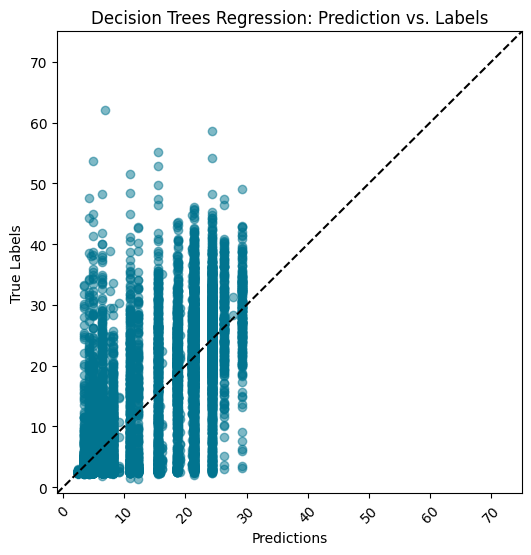

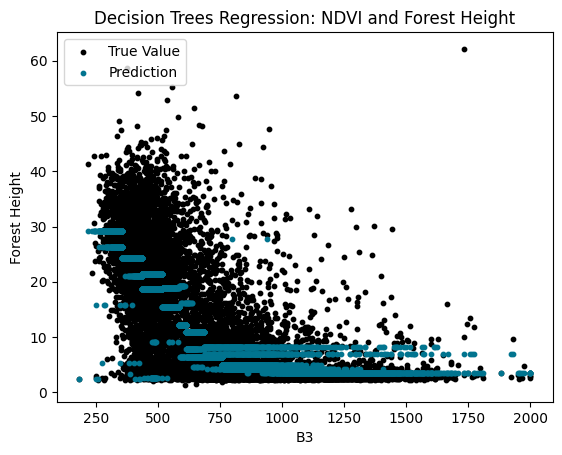

In [82]:
pred_vs_true(dt, "Decision Trees", X_test, y_pred_dt)

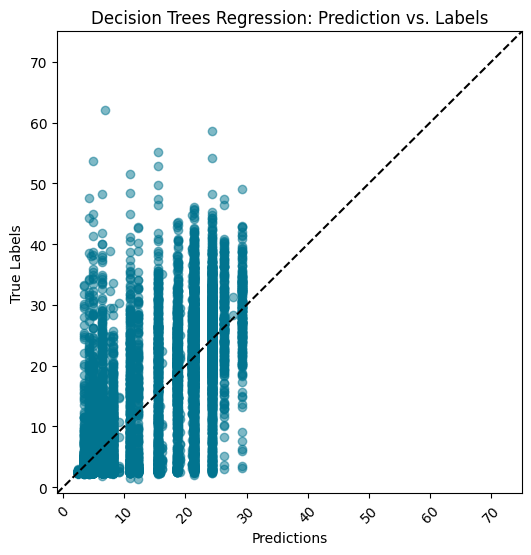

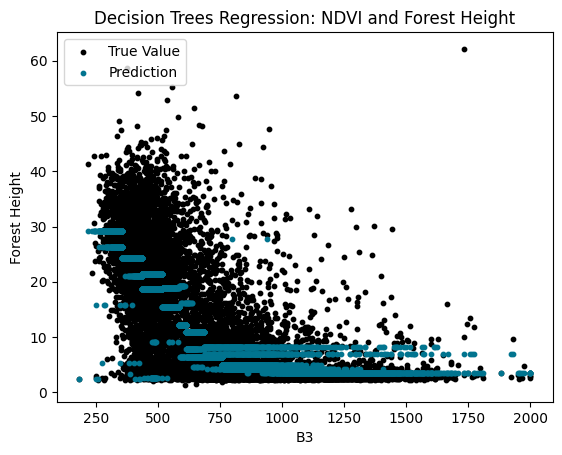

In [83]:
pred_vs_true(dt, "Decision Trees", X_test, y_pred_dt)

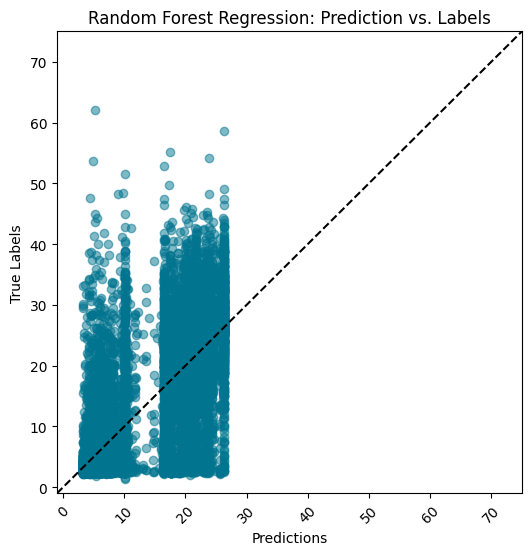

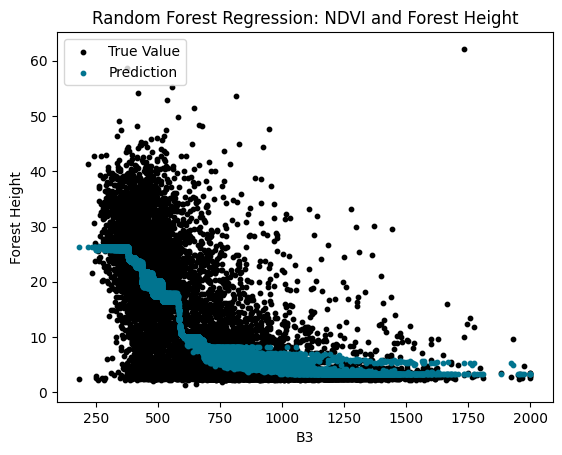

In [84]:
pred_vs_true(rf, "Random Forest", X_test, y_pred_rf)

In [88]:
#pred_vs_true(cnnmodel, "CNN", X_test_cnn, y_pred_cnn)

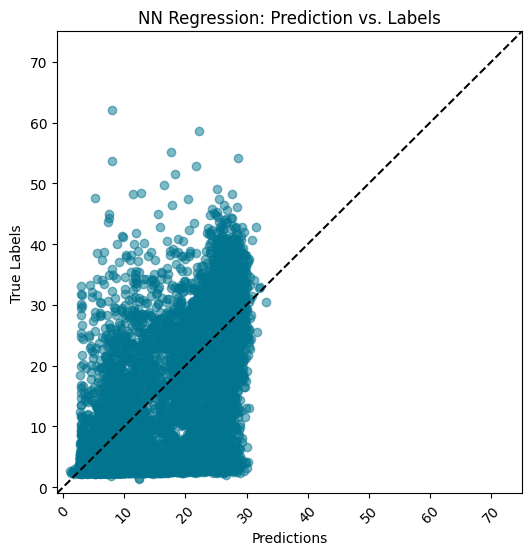

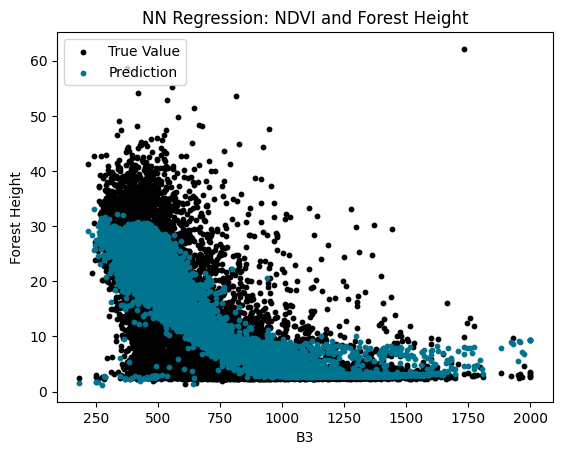

In [87]:
pred_vs_true(nnmodel, "NN", X_test, y_pred_nn)